

---

# **Pneumonia Classification using RESNET**

---







In [5]:
import cv2
import os
import random
from PIL import Image, ImageOps
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
import keras.preprocessing as preprocessing
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import regularizers
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.metrics import Recall
from keras.losses import BinaryCrossentropy
from keras import optimizers 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import scipy.misc
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')


## **1. Initializing a TPU system**




In [6]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.51.205.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.51.205.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


In [7]:
try:
 device_name = os.environ['COLAB_TPU_ADDR']
 TPU_ADDRESS = 'grpc://' + device_name
 print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
 print('TPU not found')

Found TPU at: grpc://10.51.205.106:8470


## **2. Importing data**

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
def input_fn(x,y,batch_size=0,use_batch=True):
    # Convert the inputs to a Tensorflow dataset.
    dataset = tf.data.Dataset.from_tensor_slices((x,y))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.cache()
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()

    if use_batch:
      dataset = dataset.batch(batch_size, drop_remainder=True)
      

    return dataset

def input_fn_1(x,batch_size=0,use_batch=True):
    # Convert the inputs to a Tensorflow dataset.
    dataset = tf.data.Dataset.from_tensor_slices((x))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.cache()
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()

    if use_batch:
      dataset = dataset.batch(batch_size, drop_remainder=True)
      

    return dataset

def load_data(data_dir, sample_size, use_sample_size, img_dim=64):
  
  ds = []

  label_dir = os.listdir(data_dir)
  
  for label in label_dir:

    if not(label == '.DS_Store'):
      label_dir_path = os.path.join(data_dir,label)
      filenames = os.listdir(label_dir_path)
      imgs_path = [os.path.join(label_dir_path, img_name) for img_name in filenames if img_name.endswith('.jpeg')]

      if use_sample_size: 
        imgs_path = imgs_path[:sample_size]

      print('Number of images of type {}:'.format(label),len(imgs_path))
     
      for img_path in imgs_path:
        img = Image.open(img_path)
        img = ImageOps.grayscale(img)
        img = np.array(img)
        img = np.reshape(img,(img_dim,img_dim,1))
        img = img.astype('float32')
        img = img/225
        ds.append([img,label])
  
  random.seed(1234)
  random.shuffle(ds)

  return ds

def load_tensorflow_ds(train_val=True, sample_size=255, use_sample_size=True, img_dim=64, train_batch_size=120, val_batch_size=8, test_batch_size=16):
  if train_val:
    train_ds = load_data('/content/gdrive/MyDrive/chest_xray/Resized_train_64_all',sample_size, use_sample_size, img_dim)
    labels = []
    images = []
    for x in range(len(train_ds)):
      labels.append(train_ds[x][1])
      images.append(train_ds[x][0])
    
    train_size = 5160
    X_train = images[:train_size]
    y_train = labels[:train_size]

    X_val = images[train_size:]
    y_val = labels[train_size:]

    # One-hot-encoding y_train
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(y_train)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    y_train = onehot_encoder.fit_transform(integer_encoded)

    # One-hot-encoding y_val
    integer_encoded = label_encoder.fit_transform(y_val)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    y_val = onehot_encoder.fit_transform(integer_encoded)

    print('Loading train Tensorflow dataset')
    train_ds = input_fn(X_train, y_train, train_batch_size)
    print('Loading val Tensorflow dataset')
    val_ds = input_fn(X_val, y_val, val_batch_size)

    train_val_list = [len(X_train),np.array(X_train).shape,np.array(y_train).shape]

    return train_ds,val_ds,train_val_list
  
  else:
    test_ds = load_data('/content/gdrive/MyDrive/chest_xray/Resized_test_64',sample_size, use_sample_size, img_dim)
    labels = []
    images = []

    for x in range(len(test_ds)):
      labels.append(test_ds[x][1])
      images.append(test_ds[x][0])
    X_test = images
    y_test = labels

    # One-hot-encoding y_test
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(y_test)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    y_test = onehot_encoder.fit_transform(integer_encoded)

    print('Loading test Tensorflow dataset')
    test_ds = input_fn(X_test, y_test, test_batch_size)

    test_list = [len(X_test),np.array(X_test).shape,np.array(y_test).shape]
    
    return test_ds,test_list,X_test,y_test

Loading train, val, and test datasets

In [62]:
print('\033[1mLoading train & val ds\033[0m')
train_ds,val_ds, train_val_list = load_tensorflow_ds(use_sample_size=False)
print('\033[1mLoafing test ds\033[0m')
test_ds,test_list,X_test,y_test = load_tensorflow_ds(train_val=False,use_sample_size=False)

Loading train & val ds
Number of images of type NORMAL: 1341
Number of images of type PNEUMONIA: 3875
Loading train Tensorflow dataset
Loading val Tensorflow dataset
Loafing test ds
Number of images of type NORMAL: 234
Number of images of type PNEUMONIA: 390
Loading test Tensorflow dataset


In [63]:
x_test = input_fn_1(X_test,624)

In [14]:
print ("Number of training examples:" + str(train_val_list[0]))
print ("Number of test examples:" + str(test_list[0]))
print ("X_train shape:" + str(train_val_list[1]))
print ("y_train shape:" + str(train_val_list[2]))
print ("X_test shape:" + str(test_list[1]))
print ("y_test shape:" + str(test_list[2]))

Number of training examples:5160
Number of test examples:624
X_train shape:(5160, 64, 64, 1)
y_train shape:(5160, 2)
X_test shape:(624, 64, 64, 1)
y_test shape:(624, 2)


In [ ]:
plt.figure(figsize=(10, 10))
i=0
for image, label in (X_train[0:9],y_train[0:9]):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[i].numpy().astype("uint8"))
  plt.title(label[i])
  plt.axis("off")
  i+=1

## **3. ResNet architecture**

In [15]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block 
  
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.01))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1),padding = "same", name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.01))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.01))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.01))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [16]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block 
   
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.01))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.01))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(0.01))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation("relu")(X)
    
    ### END CODE HERE ###
    
    return X


In [17]:
def ResNet(input_shape = (64, 64,1), classes = 2, rate = 0.3):
    """
    Implementation of the popular ResNet architecture

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((1, 1))(X_input)
    
    # Stage 1
    X = Conv2D(64, (3, 3), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 128], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 128], stage=2, block='c')
    X = identity_block(X, 3, [64, 64, 128], stage=2, block='d')
    X = tf.keras.layers.Dropout(rate, seed=134)(X)

    # stage 3
    X = convolutional_block(X, f = 3, filters = [64, 64, 128], stage = 3, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='b')
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='c')
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='d')
    X = tf.keras.layers.Dropout(rate, seed=234)(X)
  
    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [128, 128, 256], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 256], stage=4, block='b')
    X = identity_block(X, 3, [128, 128, 256], stage=4, block='c')
    X = identity_block(X, 3, [128, 128, 256], stage=4, block='d')
    X = tf.keras.layers.Dropout(rate, seed=124)(X)

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [128, 128, 256], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 256], stage=5, block='b')
    X = identity_block(X, 3, [128, 128, 256], stage=5, block='c')
    X = identity_block(X, 3, [128, 128, 256], stage=5, block='d')
    X = tf.keras.layers.Dropout(rate, seed=123)(X)

    # Stage 6 
    X = convolutional_block(X, f = 3, filters = [256, 256, 512], stage = 6, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 512], stage=6, block='b')
    X = identity_block(X, 3, [256, 256, 512], stage=6, block='c')
    X = identity_block(X, 3, [256, 256, 512], stage=6, block='d')
    X = tf.keras.layers.Dropout(rate, seed=14)(X)

    # Stage 7
    X = convolutional_block(X, f = 3, filters = [256, 256, 512], stage = 7, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 512], stage=7, block='b')
    X = identity_block(X, 3, [256, 256, 512], stage=7, block='c')
    X = identity_block(X, 3, [256, 256, 512], stage=7, block='d')
    X = tf.keras.layers.Dropout(rate, seed=34)(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet')

    return model

## **4. Model training**

In [18]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [80]:
with strategy.scope():
  model = ResNet()
  model.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=True),
                metrics=Recall())

In [21]:
steps_per_epoch = 5160 // 120
validation_steps = 56 // 8

weight_for_normal = 5216 / (2 * 1341 )
weight_for_pneumonia = 5216 / (2 * 3875)

weights = {0:weight_for_normal, 1:weight_for_pneumonia}

In [81]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_recall_1', mode='max',verbose=1)
history = model.fit(train_ds,
          epochs=50,
          steps_per_epoch=steps_per_epoch,
          validation_data=val_ds, 
          validation_steps=validation_steps,
          callbacks=[model_checkpoint],
          class_weight=weights)

Epoch 1/50
43/43 [==============================] - 67s 200ms/step - loss: 139.8227 - recall_2: 0.5068 - val_loss: 123.9933 - val_recall_2: 1.0000


Epoch 2/50
43/43 [==============================] - 3s 61ms/step - loss: 119.5693 - recall_2: 0.6867 - val_loss: 106.0616 - val_recall_2: 0.5893


Epoch 3/50
43/43 [==============================] - 3s 61ms/step - loss: 101.4826 - recall_2: 0.7903 - val_loss: 89.9603 - val_recall_2: 0.5893


Epoch 4/50
43/43 [==============================] - 3s 62ms/step - loss: 85.7224 - recall_2: 0.8585 - val_loss: 76.4827 - val_recall_2: 0.5893


Epoch 5/50
43/43 [==============================] - 3s 62ms/step - loss: 72.8285 - recall_2: 0.8847 - val_loss: 65.5631 - val_recall_2: 0.5893


Epoch 6/50
43/43 [==============================] - 3s 61ms/step - loss: 62.5159 - recall_2: 0.8967 - val_loss: 57.0650 - val_recall_2: 0.5893


Epoch 7/50
43/43 [==============================] - 3s 61ms/step - loss: 54.2054 - recall_2: 0.8986 - val_loss: 50.0479 - val_recall_2: 0.5893


Epoch 8/50
43/43 [==============================] - 3s 62ms/step - loss: 47.5327 - recall_2: 0.9093 - val_loss: 44.4911 - val_recall_2: 0.5893


Epoch 9/50
43/43 [==============================] - 3s 62ms/step - loss: 42.0307 - recall_2: 0.9220 - val_loss: 39.7803 - val_recall_2: 0.5893


Epoch 10/50
43/43 [==============================] - 3s 62ms/step - loss: 37.4584 - recall_2: 0.9341 - val_loss: 35.9949 - val_recall_2: 0.5893


Epoch 11/50
43/43 [==============================] - 3s 62ms/step - loss: 33.6177 - recall_2: 0.9348 - val_loss: 32.5873 - val_recall_2: 0.5893


Epoch 12/50
43/43 [==============================] - 3s 61ms/step - loss: 30.3269 - recall_2: 0.9378 - val_loss: 29.6223 - val_recall_2: 0.5893


Epoch 13/50
43/43 [==============================] - 3s 63ms/step - loss: 27.4873 - recall_2: 0.9447 - val_loss: 27.1564 - val_recall_2: 0.5893


Epoch 14/50
43/43 [==============================] - 3s 62ms/step - loss: 25.0219 - recall_2: 0.9504 - val_loss: 25.0108 - val_recall_2: 0.5893


Epoch 15/50
43/43 [==============================] - 3s 62ms/step - loss: 22.8977 - recall_2: 0.9487 - val_loss: 23.1776 - val_recall_2: 0.5893


Epoch 16/50
43/43 [==============================] - 3s 61ms/step - loss: 20.9234 - recall_2: 0.9621 - val_loss: 21.0630 - val_recall_2: 0.5893


Epoch 17/50
43/43 [==============================] - 3s 63ms/step - loss: 19.2405 - recall_2: 0.9542 - val_loss: 19.1862 - val_recall_2: 0.5893


Epoch 18/50
43/43 [==============================] - 3s 63ms/step - loss: 17.7610 - recall_2: 0.9586 - val_loss: 17.8656 - val_recall_2: 0.5893


Epoch 19/50
43/43 [==============================] - 3s 63ms/step - loss: 16.3326 - recall_2: 0.9608 - val_loss: 17.1535 - val_recall_2: 0.5893


Epoch 20/50
43/43 [==============================] - 3s 62ms/step - loss: 15.0672 - recall_2: 0.9649 - val_loss: 15.1501 - val_recall_2: 0.5893


Epoch 21/50
43/43 [==============================] - 3s 62ms/step - loss: 13.9381 - recall_2: 0.9583 - val_loss: 14.2750 - val_recall_2: 0.5893


Epoch 22/50
43/43 [==============================] - 3s 60ms/step - loss: 12.9507 - recall_2: 0.9584 - val_loss: 13.4198 - val_recall_2: 0.5893


Epoch 23/50
43/43 [==============================] - 3s 61ms/step - loss: 12.0147 - recall_2: 0.9695 - val_loss: 12.6537 - val_recall_2: 0.5893


Epoch 24/50
43/43 [==============================] - 3s 60ms/step - loss: 11.0833 - recall_2: 0.9759 - val_loss: 12.9164 - val_recall_2: 0.5893


Epoch 25/50
43/43 [==============================] - 3s 61ms/step - loss: 10.3458 - recall_2: 0.9557 - val_loss: 15.2328 - val_recall_2: 0.5893


Epoch 26/50
43/43 [==============================] - 3s 60ms/step - loss: 9.6093 - recall_2: 0.9680 - val_loss: 10.4930 - val_recall_2: 0.5893


Epoch 27/50
43/43 [==============================] - 3s 60ms/step - loss: 8.9275 - recall_2: 0.9619 - val_loss: 9.3027 - val_recall_2: 0.5893


Epoch 28/50
43/43 [==============================] - 3s 62ms/step - loss: 8.3373 - recall_2: 0.9677 - val_loss: 8.8173 - val_recall_2: 0.5893


Epoch 29/50
43/43 [==============================] - 3s 61ms/step - loss: 7.8607 - recall_2: 0.9462 - val_loss: 8.3328 - val_recall_2: 0.5893


Epoch 30/50
43/43 [==============================] - 3s 61ms/step - loss: 7.2628 - recall_2: 0.9670 - val_loss: 7.7309 - val_recall_2: 0.5893


Epoch 31/50
43/43 [==============================] - 3s 60ms/step - loss: 6.7244 - recall_2: 0.9723 - val_loss: 8.3317 - val_recall_2: 0.5893


Epoch 32/50
43/43 [==============================] - 3s 61ms/step - loss: 6.2549 - recall_2: 0.9732 - val_loss: 6.8739 - val_recall_2: 0.6964


Epoch 33/50
43/43 [==============================] - 3s 61ms/step - loss: 6.2600 - recall_2: 0.9399 - val_loss: 6.8202 - val_recall_2: 0.6964


Epoch 34/50
43/43 [==============================] - 3s 63ms/step - loss: 5.6394 - recall_2: 0.9668 - val_loss: 6.1796 - val_recall_2: 0.5893


Epoch 35/50
43/43 [==============================] - 3s 62ms/step - loss: 5.2211 - recall_2: 0.9692 - val_loss: 5.8097 - val_recall_2: 0.5893


Epoch 36/50
43/43 [==============================] - 3s 61ms/step - loss: 4.8126 - recall_2: 0.9691 - val_loss: 6.1440 - val_recall_2: 0.5893


Epoch 37/50
43/43 [==============================] - 3s 62ms/step - loss: 4.4887 - recall_2: 0.9673 - val_loss: 5.4802 - val_recall_2: 0.5893


Epoch 38/50
43/43 [==============================] - 3s 61ms/step - loss: 4.2041 - recall_2: 0.9779 - val_loss: 4.8821 - val_recall_2: 0.5893


Epoch 39/50
43/43 [==============================] - 3s 62ms/step - loss: 4.0570 - recall_2: 0.9493 - val_loss: 2359784.0000 - val_recall_2: 0.4107


Epoch 40/50
43/43 [==============================] - 3s 61ms/step - loss: 4.6028 - recall_2: 0.9238 - val_loss: 18.2897 - val_recall_2: 0.5000


Epoch 41/50
43/43 [==============================] - 3s 62ms/step - loss: 3.8579 - recall_2: 0.9573 - val_loss: 4.2032 - val_recall_2: 0.6429


Epoch 42/50
43/43 [==============================] - 3s 62ms/step - loss: 3.5464 - recall_2: 0.9648 - val_loss: 4.6720 - val_recall_2: 0.5893


Epoch 43/50
43/43 [==============================] - 3s 60ms/step - loss: 3.2300 - recall_2: 0.9618 - val_loss: 4.1561 - val_recall_2: 0.5893


Epoch 44/50
43/43 [==============================] - 3s 60ms/step - loss: 2.9945 - recall_2: 0.9590 - val_loss: 4.3263 - val_recall_2: 0.5893


Epoch 45/50
43/43 [==============================] - 3s 63ms/step - loss: 2.8417 - recall_2: 0.9617 - val_loss: 5.1508 - val_recall_2: 0.5893


Epoch 46/50
43/43 [==============================] - 3s 65ms/step - loss: 2.6244 - recall_2: 0.9792 - val_loss: 4.2841 - val_recall_2: 0.5893


Epoch 47/50
43/43 [==============================] - 3s 64ms/step - loss: 2.5202 - recall_2: 0.9757 - val_loss: 4.5424 - val_recall_2: 0.5893


Epoch 48/50
43/43 [==============================] - 3s 66ms/step - loss: 2.4052 - recall_2: 0.9717 - val_loss: 3.5701 - val_recall_2: 0.5893


Epoch 49/50
43/43 [==============================] - 3s 64ms/step - loss: 2.2896 - recall_2: 0.9689 - val_loss: 4.7801 - val_recall_2: 0.3750


Epoch 50/50
43/43 [==============================] - 3s 63ms/step - loss: 2.8335 - recall_2: 0.9593 - val_loss: 3.4411 - val_recall_2: 0.5893


In [54]:
#model.load_weights('.mdl_wts.hdf5')
model.load_weights('/content/gdrive/MyDrive/Resnet_models/model_Resnet_4_weights_recall_988.h5')

In [ ]:
model.save_weights('/content/gdrive/MyDrive/Resnet_models/model_Resnet_weights_recall_988.h5', overwrite=True)

In [83]:
preds = model.evaluate(test_ds,steps=39)
print ("Loss = " + str(preds[0]))
print ("Test Recall = " + str(preds[1]))

39/39 [==============================] - 10s 22ms/step - loss: 4.2201 - recall_2: 0.6250
Loss = 4.220149517059326
Test Recall = 0.625


In [82]:
from sklearn.metrics import classification_report
predictions = model.predict(x_test,steps = 1)
#predictions = predictions.reshape(1,-1)[0]
predictions = np.argmax(predictions, axis=1)
#y_test = np.argmax(y_test, axis=1)
#report = classification_report(, predicted)

print(classification_report(np.argmax(y_test, axis=1), list(predictions), target_names = ['NORMAL (Class 0)','PNEUMONIA (Class 1)']))

                     precision    recall  f1-score   support

   NORMAL (Class 0)       0.00      0.00      0.00       234
PNEUMONIA (Class 1)       0.62      1.00      0.77       390

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.argmax(y_test, axis=1),predictions)

array([[  0, 234],
       [  0, 390]])

In [79]:
255/(255+135)

0.6538461538461539

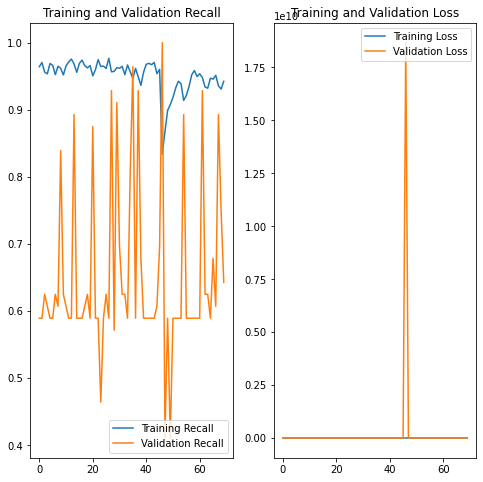

In [34]:
epochs = 70
acc = history.history['recall']
val_acc = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Recall')
plt.plot(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
model.summary()

Model: "ResNet50_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 66, 66, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   640         zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
_________________________________________________________________________________________

In [25]:
len(model.layers)

266

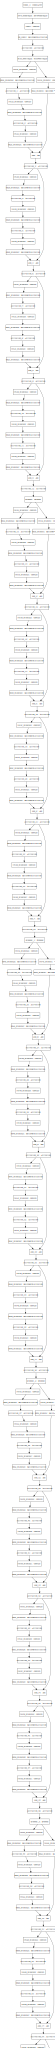

In [27]:
plot_model(model, to_file='resnet_model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [60]:
imshow(X_test[0].astype("uint8"))
#plt.axis("off")


SyntaxError: ignored